In [33]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torch.optim import SGD

import numpy as np
from numpy import dot
import matplotlib.pyplot as plt

In [34]:
input_size = 784
hidden_size = 2048
num_classes = 10
num_epochs = 50
batch_size = 50
learning_rate = 0.1

M_train = 1000
M_test = 200

In [35]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='StandardData', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='StandardData', 
                                          train=False, 
                                          transform=transforms.ToTensor())

reduced_train_index=list(range(M_train))
reduced_test_index=list(range(M_test))

subset_train_dataset=Subset(train_dataset, reduced_train_index)
subset_test_dataset=Subset(test_dataset, reduced_test_index)

# Data loader
train_loader = DataLoader(dataset=subset_train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=subset_test_dataset, batch_size=batch_size, shuffle=False) 

In [36]:
# Fully connected neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size) 
        self.output_layer = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        x = self.input_layer(x)
        x = x.relu()
        x = self.output_layer(x)
        return x
    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [37]:
# Train the model

model_RealData = NeuralNet(input_size, hidden_size, num_classes)
ReLU_glorot_init(model_RealData)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model_RealData.parameters(), lr=learning_rate)

def train_epoch():

    no_parameters=input_size*hidden_size+hidden_size+hidden_size*num_classes+num_classes
    expected_gradient=np.zeros(no_parameters)
    expected_dot=0
    counter=0

    for images, labels in train_loader:
        images = images.reshape(-1, 28*28)
        outputs = model_RealData(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        batch_gradient=[]
        for ten in model_RealData.input_layer.weight.grad:
            batch_gradient+=ten.tolist()
        batch_gradient+=model_RealData.input_layer.bias.grad.tolist()
        for ten in model_RealData.output_layer.weight.grad:
            batch_gradient+=ten.tolist()
        batch_gradient+=model_RealData.output_layer.bias.grad.tolist()
        optimizer.step()
        batch_gradient=np.array(batch_gradient)
        expected_gradient+=batch_gradient
        expected_dot+=dot(batch_gradient,batch_gradient)
        counter+=1
    expected_dot=expected_dot/counter
    expected_gradient=expected_gradient/counter

    batchwise_coherence=dot(expected_gradient,expected_gradient)/expected_dot
    k=len(train_loader)
    perexample_coherence=batchwise_coherence/(k-(k-1)*batchwise_coherence)
    return loss.item(), perexample_coherence*M_train

def accuracy(loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            outputs = model_RealData(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        return correct/total

def loss(loader):
    with torch.no_grad():
        loss = 0
        total = 0
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            outputs = model_RealData(images)
            loss += criterion(outputs, labels).item()*labels.size(0)
            total += labels.size(0)
        return loss/total

train_loss=[]
train_accuracy=[]
test_loss=[]
test_accuracy=[]
epoch_list=[]
alpha_list=[]

for epoch in range(num_epochs):
    trainloss, alpha = train_epoch()
    train_loss.append(trainloss)
    alpha_list.append(alpha)
    train_accuracy.append(accuracy(train_loader))
    test_loss.append(loss(test_loader))
    test_accuracy.append(accuracy(test_loader))
    epoch_list.append(epoch)
    print('Epoch: {} TrainLoss: {:.3f} TestLoss: {:.3f} TrainAccuracy: {:.3f} TestAccuracy: {:.3f} Coherence: {:.3f}'.format(epoch+1,train_loss[-1],test_loss[-1],train_accuracy[-1],test_accuracy[-1],alpha_list[-1]))

Epoch: 1 TrainLoss: 0.934 TestLoss: 1.062 TrainAccuracy: 0.837 TestAccuracy: 0.760 Coherence: 14.645
Epoch: 2 TrainLoss: 0.663 TestLoss: 0.717 TrainAccuracy: 0.877 TestAccuracy: 0.815 Coherence: 5.825
Epoch: 3 TrainLoss: 0.616 TestLoss: 0.595 TrainAccuracy: 0.904 TestAccuracy: 0.855 Coherence: 2.616
Epoch: 4 TrainLoss: 0.413 TestLoss: 0.508 TrainAccuracy: 0.919 TestAccuracy: 0.875 Coherence: 2.341
Epoch: 5 TrainLoss: 0.464 TestLoss: 0.474 TrainAccuracy: 0.935 TestAccuracy: 0.850 Coherence: 1.586
Epoch: 6 TrainLoss: 0.326 TestLoss: 0.441 TrainAccuracy: 0.934 TestAccuracy: 0.865 Coherence: 1.355
Epoch: 7 TrainLoss: 0.334 TestLoss: 0.408 TrainAccuracy: 0.949 TestAccuracy: 0.895 Coherence: 1.315
Epoch: 8 TrainLoss: 0.261 TestLoss: 0.382 TrainAccuracy: 0.956 TestAccuracy: 0.905 Coherence: 1.169
Epoch: 9 TrainLoss: 0.197 TestLoss: 0.367 TrainAccuracy: 0.955 TestAccuracy: 0.920 Coherence: 1.120
Epoch: 10 TrainLoss: 0.261 TestLoss: 0.356 TrainAccuracy: 0.967 TestAccuracy: 0.915 Coherence: 0.91

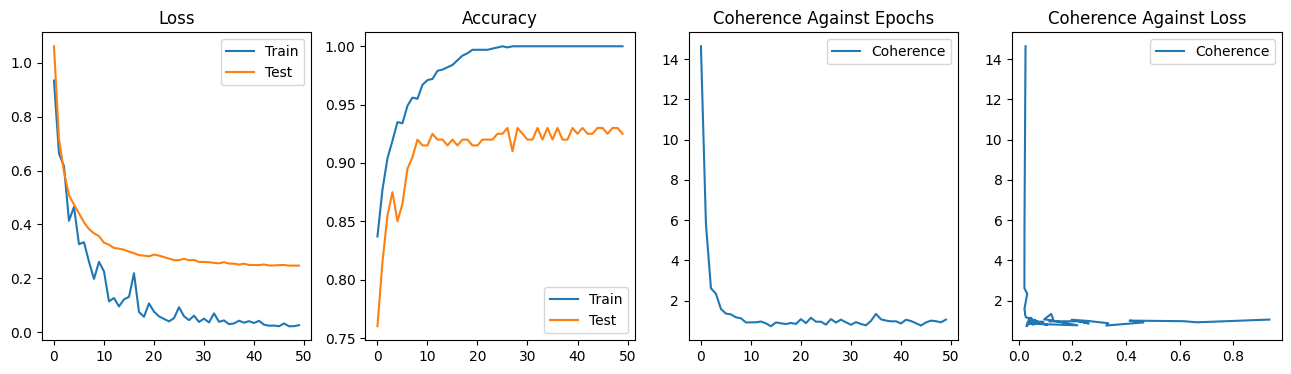

In [43]:
fig, axs = plt.subplots(1,4)

fig.set_size_inches(16,4)

axs[0].plot(np.arange(num_epochs), train_loss,label='Train')
axs[0].plot(np.arange(num_epochs), test_loss,label='Test')
axs[0].set_title('Loss')
axs[0].legend()
axs[1].plot(np.arange(num_epochs), train_accuracy,label='Train')
axs[1].plot(np.arange(num_epochs), test_accuracy,label='Test')
axs[1].set_title('Accuracy')
axs[1].legend()
axs[2].plot(np.arange(num_epochs), alpha_list,label='Coherence')
axs[2].set_title('Coherence Against Epochs')
axs[2].legend()
axs[3].plot(np.flip(train_loss), alpha_list,label='Coherence')
axs[3].set_title('Coherence Against Loss')
axs[3].legend()

In [39]:
batch_size = 25

In [40]:
# MNIST dataset 
random_train_dataset = torchvision.datasets.MNIST(root='ShuffledData', 
                                           train=True, 
                                           transform=transforms.ToTensor(), 
                                           target_transform=lambda y: torch.randint(0, 4, (1,)).item() if y<=4 else y, 
                                           download=True)

random_test_dataset = torchvision.datasets.MNIST(root='ShuffledData', 
                                          train=False, 
                                          transform=transforms.ToTensor(),
                                          target_transform=lambda y: torch.randint(0, 4, (1,)).item() if y<=4 else y)

reduced_train_index=list(range(M_train))
reduced_test_index=list(range(M_test))

subset_random_train_dataset=Subset(random_train_dataset, reduced_train_index)
subset_random_test_dataset=Subset(random_test_dataset, reduced_test_index)

# Data loader
random_train_loader = DataLoader(dataset=subset_random_train_dataset, batch_size=batch_size, shuffle=True)

random_test_loader = DataLoader(dataset=subset_random_test_dataset, batch_size=batch_size, shuffle=False) 

In [41]:
model_RandomData = NeuralNet(input_size, hidden_size, num_classes)
ReLU_glorot_init(model_RandomData)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model_RandomData.parameters(), lr=learning_rate) 

def r_train_epoch():

    no_parameters=input_size*hidden_size+hidden_size+hidden_size*num_classes+num_classes
    expected_gradient=np.zeros(no_parameters)
    expected_dot=0
    counter=0

    for images, labels in random_train_loader:
        images = images.reshape(-1, 28*28)
        outputs = model_RandomData(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        batch_gradient=[]
        for ten in model_RandomData.input_layer.weight.grad:
            batch_gradient+=ten.tolist()
        batch_gradient+=model_RandomData.input_layer.bias.grad.tolist()
        for ten in model_RandomData.output_layer.weight.grad:
            batch_gradient+=ten.tolist()
        batch_gradient+=model_RandomData.output_layer.bias.grad.tolist()
        optimizer.step()
        batch_gradient=np.array(batch_gradient)
        expected_gradient+=batch_gradient
        expected_dot+=dot(batch_gradient,batch_gradient)
        counter+=1
    expected_dot=expected_dot/counter
    expected_gradient=expected_gradient/counter

    batchwise_coherence=dot(expected_gradient,expected_gradient)/expected_dot
    k=len(random_train_loader)
    perexample_coherence=batchwise_coherence/(k-(k-1)*batchwise_coherence)
    return loss.item(), perexample_coherence*M_train

def r_accuracy(loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            labels = labels
            outputs = model_RandomData(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        return correct/total

def r_loss(loader):
    with torch.no_grad():
        loss = 0
        total = 0
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            labels = labels
            outputs = model_RandomData(images)
            loss += criterion(outputs, labels).item()*labels.size(0)
            total += labels.size(0)
        return loss/total

random_train_loss=[]
random_train_accuracy=[]
random_test_loss=[]
random_test_accuracy=[]
random_alpha_list=[]

for epoch in range(num_epochs):
    random_trainloss, random_alpha = r_train_epoch()
    random_train_loss.append(random_trainloss)
    random_alpha_list.append(random_alpha)
    random_train_accuracy.append(r_accuracy(random_train_loader))
    random_test_loss.append(r_loss(random_test_loader))
    random_test_accuracy.append(r_accuracy(random_test_loader))
    print('Epoch: {} TrainLoss: {:.3f} TestLoss: {:.3f} TrainAccuracy: {:.3f} TestAccuracy: {:.3f} Coherence: {:.3f}'.format(epoch+1,random_train_loss[-1],random_test_loss[-1],random_train_accuracy[-1],random_test_accuracy[-1],random_alpha_list[-1]))

Epoch: 1 TrainLoss: 1.710 TestLoss: 1.445 TrainAccuracy: 0.536 TestAccuracy: 0.490 Coherence: 1.083
Epoch: 2 TrainLoss: 1.052 TestLoss: 1.348 TrainAccuracy: 0.548 TestAccuracy: 0.510 Coherence: 0.345
Epoch: 3 TrainLoss: 1.049 TestLoss: 1.253 TrainAccuracy: 0.567 TestAccuracy: 0.500 Coherence: 0.280
Epoch: 4 TrainLoss: 0.928 TestLoss: 1.256 TrainAccuracy: 0.583 TestAccuracy: 0.510 Coherence: 0.270
Epoch: 5 TrainLoss: 0.825 TestLoss: 1.154 TrainAccuracy: 0.589 TestAccuracy: 0.485 Coherence: 0.293
Epoch: 6 TrainLoss: 1.051 TestLoss: 1.138 TrainAccuracy: 0.610 TestAccuracy: 0.580 Coherence: 0.265
Epoch: 7 TrainLoss: 0.745 TestLoss: 1.103 TrainAccuracy: 0.598 TestAccuracy: 0.540 Coherence: 0.297
Epoch: 8 TrainLoss: 0.945 TestLoss: 1.132 TrainAccuracy: 0.615 TestAccuracy: 0.560 Coherence: 0.258
Epoch: 9 TrainLoss: 0.823 TestLoss: 1.108 TrainAccuracy: 0.611 TestAccuracy: 0.570 Coherence: 0.272
Epoch: 10 TrainLoss: 0.725 TestLoss: 1.069 TrainAccuracy: 0.602 TestAccuracy: 0.515 Coherence: 0.239

Text(0.5, 1.0, 'Coherence Against Loss')

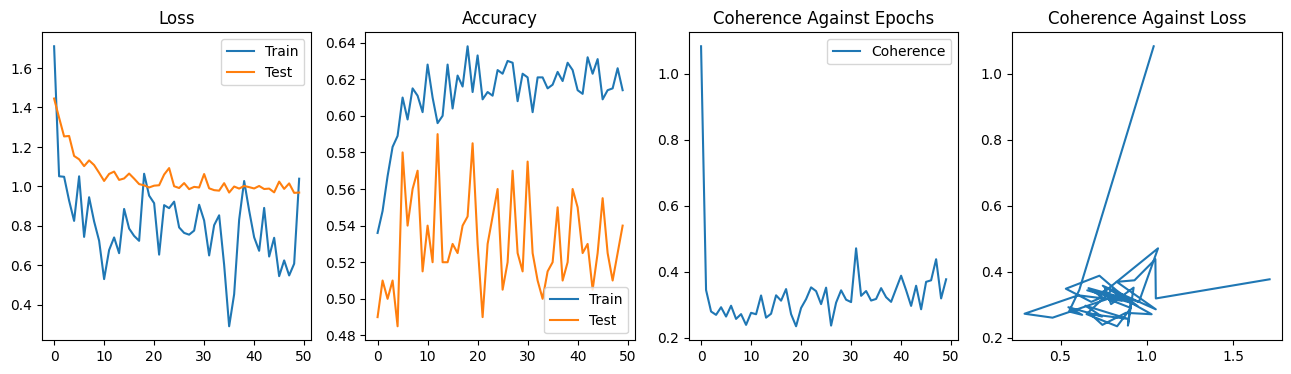

In [44]:
fig, axs = plt.subplots(1,4)

fig.set_size_inches(16,4)

axs[0].plot(np.arange(num_epochs), random_train_loss,label='Train')
axs[0].plot(np.arange(num_epochs), random_test_loss,label='Test')
axs[0].set_title('Loss')
axs[0].legend()
axs[1].plot(np.arange(num_epochs), random_train_accuracy,label='Train')
axs[1].plot(np.arange(num_epochs), random_test_accuracy,label='Test')
axs[1].set_title('Accuracy')
axs[1].legend()
axs[2].plot(np.arange(num_epochs), random_alpha_list,label='Coherence')
axs[2].set_title('Coherence Against Epochs')
axs[2].legend()
axs[3].plot(np.flip(random_train_loss), random_alpha_list,label='Coherence')
axs[3].set_title('Coherence Against Loss')

Here approximately $50$% of the data is clean and the rest is randomized. Hence, we see that accuracy is much lower than the clean case.